In [5]:
!pip install torch easydict seaborn

In [6]:
# === 🔧 Environment Setup ===
# Imports core libraries for data handling, ML, statistics, visualization, and system ops
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.autograd as autograd
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import time
from easydict import EasyDict
import torch.backends.cudnn as cudnn
from sklearn.preprocessing import StandardScaler
import joblib
from scipy.stats import skew, kurtosis, jarque_bera, ks_2samp
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

In [7]:
# Select GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === 📈 Load and Normalize Dataset ===
# Read and compute returns, then scale for stable training
raw_df = pd.read_csv("raw (FX + EQ).csv").dropna()
raw_returns = raw_df.pct_change().dropna().values
scaler = StandardScaler()
scaler.fit(raw_returns)



StandardScaler(copy=True, with_mean=True, with_std=True)

In [8]:
# === 🎛️ Generator Model for FX/EQ returns ===
class FXEQGenerator(nn.Module):
    def __init__(self, z_size=100, out_dim=20*1):
        super(FXEQGenerator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(z_size, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, out_dim)
        )

    def forward(self, z):
        return self.fc(z).view(-1, 20, 1)  # output: [batch, sequence_len, 1]


# === 🕵️ Discriminator Model ===
class FXEQDiscriminator(nn.Module):
    def __init__(self, in_dim=20*1):
        super(FXEQDiscriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.fc(x.view(x.size(0), -1))  # flatten input



In [9]:
# === 📦 Time Series Dataset with Windowing ===
class FXEQDataset(Dataset):
    def __init__(self, csv_path, window_size=20, scaler=None, asset_index=0, split='train', split_ratio=0.65):
        self.data = pd.read_csv(csv_path).dropna()
        self.returns = self.data.pct_change().dropna().values[:, asset_index]
        self.returns = self.returns.reshape(-1, 1)

        # Split into train/test
        split_point = int(len(self.returns) * split_ratio)
        if split == 'train':
            self.returns = self.returns[:split_point]
        elif split == 'test':
            self.returns = self.returns[split_point:]

        if scaler is not None:
            self.returns = scaler.transform(self.returns)

        self.returns = self.returns.squeeze()
        self.window_size = window_size
        self.samples = [self.returns[i:i+window_size] for i in range(len(self.returns) - window_size)]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return torch.tensor(self.samples[idx], dtype=torch.float32).unsqueeze(1)  # shape: [window, 1]



In [10]:
# === 🔢 Utility Functions ===
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def save_checkpoint(state, filename='checkpoint'):
    torch.save(state, filename + '.pth.tar')

def to_tensor(x):
    return x.clone().detach().to(device)

In [11]:
# -- ARGUMENT PARSER --
def parse():
    parser = argparse.ArgumentParser()
    """
    Hyper-parameter for Stochastic Gradient Hamiltonian Monte Carlo
    """
    parser.add_argument('--sghmc_alpha', default=0.01, type=int, dest='sghmc_alpha', help='number of generators')
    parser.add_argument('--g_noise_loss_lambda', default=3e-2, type=float, dest='g_noise_loss_lambda')
    parser.add_argument('--d_noise_loss_lambda', default=3e-2, type=float, dest='d_noise_loss_lambda')
    parser.add_argument('--d_hist_loss_lambda', default=1.0, type=float, dest='d_hist_loss_lambda')
    """
    GAN objectives
    NS: original GAN (Non-saturating version)
    MM: original GAN (Min-max version)
    W: Wasserstein GAN
    LS: Least-Square GAN
    """
    parser.add_argument('--gan_obj', default='NS', type=str, dest='gan_obj', help='[NS | MM | LS | W]')

    """
    Paths
    """
    parser.add_argument('--dataset', default='fxeq', type=str, dest='dataset',
                        help='dataset: [cifar10, stl10, imagenet]')
    parser.add_argument('--save_dir', default='none', type=str, dest='save_dir', help='save_path')

    return parser.parse_args()


In [12]:
# -- MODEL CONSTRUCTOR --
def construct_model(args, config):
    """Constructs generator and discriminator models based on dataset type and config"""
    '''
    :param args: Experiment Information
    :param config: Neural Network Architecture Configurations
    :return:
        G: generator structure
        D: discriminator structure
    '''
    D_unbound_output = args.gan_obj in ['W', 'LS']  # Whether discriminator output is bounded

    if args.dataset == 'fxeq':
        G = FXEQGenerator(z_size=config.z_size).to(device)
        D = FXEQDiscriminator().to(device)
    else:
        raise NotImplementedError("Only 'fxeq' dataset supported in this version")

    print('G #parameters: ', count_parameters(G))
    print('D #parameters: ', count_parameters(D))
    return G, D

In [43]:
# -- TRAINING FUNCTION --
def train_net(G, D, args, config):
    """Train GAN model using selected GAN objective"""
    is_multi_g = hasattr(G, 'gs')  # Used in multi-generator architectures
    is_multi_d = hasattr(D, 'ds') or hasattr(D, 'forward_by_hist')  # Multi-discriminator support

    print(f"Using device: {device}")
    cudnn.benchmark = True

    # SGHMC noise setup
    noise_std = np.sqrt(2 * args.sghmc_alpha)
    G_noise_sampler = [get_sghmc_noise(g) for g in G.gs] if is_multi_g else [get_sghmc_noise(G)]
    D_noise_sampler = get_sghmc_noise(D)

    # Output directory setup
    if args.save_dir == 'none':
        args.save_dir = f'./dump/train_{args.dataset}_{args.gan_obj}'
    os.makedirs(args.save_dir, exist_ok=True)

    # Dataset and dataloader
    train_loader = torch.utils.data.DataLoader(
        dataset=config.get_dataset(),
        batch_size=config.batch_size, shuffle=True,
        num_workers=config.workers, pin_memory=True)

    # Loss functions
    criterion_bce = nn.BCEWithLogitsLoss().to(device)
    criterion_mse = nn.MSELoss().to(device)

    # Define GAN losses based on objective
    if args.gan_obj == 'NS':  # Non-saturating GAN
        phi_1 = lambda dreal, lreal, lfake: criterion_bce(dreal, lreal)
        phi_2 = lambda dfake, lreal, lfake: criterion_bce(dfake, lfake)
        phi_3 = lambda dfake, lreal, lfake: criterion_bce(dfake, lreal)
    elif args.gan_obj == 'MM':  # Min-max GAN
        phi_1 = lambda dreal, lreal, lfake: criterion_bce(dreal, lreal)
        phi_2 = lambda dfake, lreal, lfake: criterion_bce(dfake, lfake)
        phi_3 = lambda dfake, lreal, lfake: -criterion_bce(dfake, lfake)
    elif args.gan_obj == 'LS':  # Least-squares GAN
        phi_1 = lambda dreal, lreal, lfake: criterion_mse(dreal, lreal)
        phi_2 = lambda dfake, lreal, lfake: criterion_mse(dfake, lfake)
        phi_3 = lambda dfake, lreal, lfake: criterion_mse(dfake, lreal)
    elif args.gan_obj == 'W':  # Wasserstein GAN
        phi_1 = lambda dreal, lreal, lfake: -dreal.mean()
        phi_2 = lambda dfake, lreal, lfake: dfake.mean()
        phi_3 = lambda dfake, lreal, lfake: -dfake.mean()
    else:
        raise ValueError("Unknown GAN objective")

    # Optimizers
    optimizerD = torch.optim.Adam(D.parameters(), lr=config.base_lr, betas=(config.beta1, 0.999))
    optimizerG = torch.optim.Adam(G.parameters(), lr=config.base_lr, betas=(config.beta1, 0.999))

    # Tracking meters
    batch_time = AverageMeter()
    data_time = AverageMeter()
    D_losses = AverageMeter()
    G_losses = AverageMeter()
    G_n_losses = AverageMeter()

    # Loss history lists for plotting
    D_loss_list = []
    G_loss_list = []
    G_loss_by_hist_list = []
    
    # Fixed noise for sampling
    fixed_noise = torch.randn(100, config.z_size).to(device)

    # Start training loop
    for epoch in range(config.epoches):
        end = time.time()
        G.train(); D.train()

        for i, input in enumerate(train_loader):
            data_time.update(time.time() - end)
            batch_size = input.size(0)
            g_batch_size = config.g_batch_size

            # ----------------------- Train Discriminator -----------------------
            real_input = Variable(input.to(device))
            label_real = Variable(torch.ones(batch_size).to(device))
            label_fake = Variable(torch.zeros(g_batch_size).to(device))

            # Real loss
            d_real = D(real_input).squeeze()
            loss_real = phi_1(d_real, label_real, None)

            # Fake generation
            noise = torch.randn(g_batch_size, config.z_size).to(device)
            fake_data = G(noise)
            d_fake = D(fake_data).squeeze()
            loss_fake = phi_2(d_fake, None, label_fake)

            # Total discriminator loss
            d_loss = loss_real + loss_fake
            D_losses.update(d_loss.item())

            # SGHMC noise loss for discriminator
            d_loss += args.d_noise_loss_lambda * noise_loss(D, D_noise_sampler, noise_std)

            # Optional gradient penalty (for WGAN)
            if args.gan_obj == 'W':
                d_loss += calc_gradient_penalty(D, real_input.data, fake_data[:batch_size].data)

            D.zero_grad(); d_loss.backward(); optimizerD.step()

            # ----------------------- Train Generator -----------------------
            noise = torch.randn(g_batch_size, config.z_size).to(device)
            fake_data = G(noise)
            d_fake = D(fake_data).squeeze()

            # Regenerate correct-size labels for generator training (g_batch_size)
            label_real_g = torch.ones(g_batch_size).to(device)
            label_fake_g = torch.zeros(g_batch_size).to(device)

            g_loss = phi_3(d_fake, label_real_g, label_fake_g)

            G_losses.update(g_loss.item())
            g_loss += args.g_noise_loss_lambda * noise_loss(G, G_noise_sampler[0], noise_std)

            # History-aware discriminator loss (if available)
            if is_multi_d and hasattr(D, 'forward_by_hist'):
                d_fake_hist = D.forward_by_hist(fake_data).squeeze()
                g_hist_loss = phi_3(d_fake_hist, label_real_g, label_fake_g)
                g_loss += g_hist_loss * args.d_hist_loss_lambda
                G_n_losses.update(g_hist_loss.item())


            D.zero_grad(); G.zero_grad(); g_loss.backward(); optimizerG.step()
            batch_time.update(time.time() - end); end = time.time()

            if is_multi_d and hasattr(D, 'update_hist') and i % 10 == 0:
                D.update_hist()

            # Print status
            if (i + 1) % config.display == 0 or (i + 1) == len(train_loader):
                print_log_2(epoch + 1, config.epoches, i + 1, len(train_loader), config.base_lr,
                            config.display, batch_time, data_time, D_losses, G_losses, G_n_losses)
                batch_time.reset(); data_time.reset()

        # End of epoch evaluation + plotting
        D_loss_list.append(D_losses.avg)
        G_loss_list.append(G_losses.avg)
        G_loss_by_hist_list.append(G_n_losses.avg)
        D_losses.reset(); G_losses.reset(); G_n_losses.reset()

        if (epoch + 1) % config.dump_ep == 0:
            plot_result(G, fixed_noise, config.image_size, epoch + 1, args.save_dir, is_gray=(config.channel_size == 1))
            plot_loss_my(D_loss_list, G_loss_list, G_loss_by_hist_list, epoch + 1, config.epoches, args.save_dir)
            save_checkpoint({'epoch': epoch, 'state_dict': D.state_dict()}, os.path.join(args.save_dir, f'D_epoch_{epoch}.pth'))
            save_checkpoint({'epoch': epoch, 'state_dict': G.state_dict()}, os.path.join(args.save_dir, f'G_epoch_{epoch}.pth'))
            torch.save(G.state_dict(), os.path.join(args.save_dir, 'gen_model.pt'))

        # Log gradient norms for generator and discriminator
        g_norm, g_max = grad_info(G.parameters())
        d_norm, d_max = grad_info(D.parameters())
        print(f"G grad l2-norm: {g_norm:.6f}, max value: {g_max:.6f}")
        print(f"D grad l2-norm: {d_norm:.6f}, max value: {d_max:.6f}")

        # Gradient clipping (optional but can stabilize training)
        nn.utils.clip_grad_norm_(G.parameters(), max_norm=100)
        nn.utils.clip_grad_norm_(D.parameters(), max_norm=500)


In [44]:
# -- Cross-validation split for time series data --
def time_series_cv_split(data, window_size=20, train_size=0.65, val_window=100, step=50):
    """
    Returns a list of (train, validation) pairs from a single time series,
    using rolling window split strategy.
    """
    n = len(data)
    split_point = int(n * train_size)
    splits = []

    for start in range(0, split_point - window_size - val_window + 1, step):
        train_end = start + window_size
        val_end = train_end + val_window
        if val_end > n:
            break
        train_data = data[start:train_end]
        val_data = data[train_end:val_end]
        splits.append((train_data.copy(), val_data.copy()))

    return splits

In [45]:
# -- SGHMC noise injection --
def noise_loss(model, noise_sampler, alpha):
    """Applies SGHMC noise to model parameters for regularization"""
    loss = 0
    for p, n in zip(model.parameters(), noise_sampler):
        n.normal_(mean=0, std=alpha)
        loss += torch.sum(p * n)
    return loss

def get_sghmc_noise(model):
    """Creates zero-initialized noise buffers for SGHMC"""
    return [to_tensor(torch.zeros(p.size())) for p in model.parameters()]

In [46]:
# -- Utility for tracking averages over time --
class AverageMeter:
    """Tracks average and current value of a quantity"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0.
        self.avg = 0.
        self.sum = 0.
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [47]:
# -- Gradient statistics logging --
def grad_info(parameters):
    total_norm = 0
    total_abs_max = 0
    for p in parameters:
        if p.requires_grad:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
            vmax = p.grad.data.abs().max().item()
            if vmax > total_abs_max:
                total_abs_max = vmax
    total_norm = total_norm ** 0.5
    return total_norm, total_abs_max

In [48]:
# -- Gradient penalty calculation (WGAN-GP) --
def calc_gradient_penalty(netD, real_data, fake_data, gp_lambda=10):
    """Compute WGAN-GP gradient penalty"""
    alpha = torch.rand(len(real_data), 1, 1, 1).to(device)
    interpolates = alpha * real_data + (1 - alpha) * fake_data
    interpolates = Variable(interpolates, requires_grad=True)
    disc_interpolates = netD(interpolates)
    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
    return ((gradients.norm(2, dim=1) - 1) ** 2).mean() * gp_lambda

# -- Optional variant for multi-GAN architectures --
def calc_gradient_penalty_mgan(netD, real_data, fake_data, gp_lambda=10):
    alpha = torch.rand(len(real_data), 1, 1, 1).to(device)
    interpolates = alpha * real_data + (1 - alpha) * fake_data
    interpolates = Variable(interpolates, requires_grad=True)
    disc_interpolates, _ = netD(interpolates)
    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
    return ((gradients.norm(2, dim=1) - 1) ** 2).mean() * gp_lambda

In [49]:
# -- Rolling Window CV Split --
def rolling_window_splits(data, window_size=20, test_size=100, step=10):
    """Generate rolling window splits for univariate time series."""
    splits = []
    for start in range(0, len(data) - window_size - test_size, step):
        train = data[start:start+window_size]
        test = data[start+window_size:start+window_size+test_size]
        splits.append((train, test))
    return splits

In [50]:
# -- Plot Training Loss Curves --
def plot_loss_my(d_loss, g_loss, g_loss_hist, num_epoch, epoches, save_dir):
    """Plot loss curves for discriminator, generator, and generator (hist)."""
    fig, ax = plt.subplots()
    ax.set_xlim(0, epoches + 1)
    ax.set_ylim(min(np.min(g_loss_hist), min(np.min(g_loss), np.min(d_loss))) - 0.1,
                max(np.max(g_loss), np.max(d_loss)) * 1.1)
    plt.xlabel(f'Epoch {num_epoch}')
    plt.ylabel('Loss')

    plt.plot(range(1, num_epoch + 1), d_loss, label='Discriminator', color='red', linewidth=3)
    plt.plot(range(1, num_epoch + 1), g_loss, label='Generator', color='mediumblue', linewidth=3, alpha=0.5)
    plt.plot(range(1, num_epoch + 1), g_loss_hist, label='Generator - (hist)', color='green', linewidth=3, alpha=0.5)

    plt.legend()
    plt.savefig(os.path.join(save_dir, f'DCGAN_loss_epoch_{num_epoch}.png'))
    plt.close()

In [51]:
# -- Visualize Generated Samples (time series) --
def plot_result(G, fixed_noise, image_size, num_epoch, save_dir, is_gray=False, n_series=None):
    """Plot a single sample from the generator's output across all series."""
    G.eval()
    with torch.no_grad():
        generated = G(fixed_noise).cpu().numpy()  # shape: [1, timesteps, features]

    if n_series is None:
        n_series = generated.shape[2]

    fig, axes = plt.subplots(n_series, 1, figsize=(12, 2 * n_series), sharex=True)
    if n_series == 1:
        axes = [axes]

    for i in range(n_series):
        series = generated[0, :, i]
        axes[i].plot(series)
        axes[i].set_ylabel(f'Series {i+1}')
        axes[i].grid(True)

    axes[-1].set_xlabel("Timestep")
    fig.suptitle(f"Generated Time Series Sample - Epoch {num_epoch}")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"time_series_epoch_{num_epoch}.png"))
    plt.close()

In [52]:
# -- Print Epoch Summary Log --
def print_log_2(epoch, epoches, iteration, iters, learning_rate,
                display, batch_time, data_time, D_losses, G_losses, G_n_losses):
    print('epoch: [{}/{}] iteration: [{}/{}]\tLearning rate: {}'.format(
        epoch, epoches, iteration, iters, learning_rate))
    print('Time {batch_time.sum:.3f}s / {0} iters, ({batch_time.avg:.3f})\t'
          'Data load {data_time.sum:.3f}s / {0} iters, ({data_time.avg:3f})\n'
          'Loss_D = {loss_D.val:.8f} (ave = {loss_D.avg:.8f})\n'
          'Loss_G = {loss_G.val:.8f} (ave = {loss_G.avg:.8f})\n'
          'Loss_GN = {loss_GN.val:.8f} (ave = {loss_GN.avg:.8f})\n'.format(
        display, batch_time=batch_time, data_time=data_time,
        loss_D=D_losses, loss_G=G_losses, loss_GN=G_n_losses))
    print(time.strftime('%Y-%m-%d %H:%M:%S\n' + '-' * 120 + '\n', time.localtime()))

In [65]:
# -- Generate Synthetic Forecast from Generator --
def generate_synthetic_forecast(G, forecast_horizon=300, n_samples=1, steps_per_pass=20):
    """Generate synthetic price forecasts from trained generator."""
    n_passes = forecast_horizon // steps_per_pass
    all_returns = []

    if scaler is None:
        raise ValueError("Scaler must be provided to inverse transform returns.")

    with torch.no_grad():
        for _ in range(n_passes):
            z = torch.randn(n_samples, 100).to(device)
            returns_block = G(z).cpu().numpy()
            all_returns.append(returns_block)

    returns = np.concatenate(all_returns, axis=1)  # shape: (1, horizon, features)

    # Inverse scale and compute price paths
    returns_flat = returns.reshape(-1, returns.shape[2])
    returns_unscaled = scaler.inverse_transform(returns_flat)
    returns = returns_unscaled.reshape(returns.shape)

    prices = []
    for i in range(returns.shape[2]):
        series = returns[0, :, i]
        series_prices = [LAST_KNOWN_PRICES[i]]
        for r in series:
            series_prices.append(series_prices[-1] * (1 + r))
        prices.append(series_prices[1:])

    df_synthetic = pd.DataFrame(np.array(prices).T, columns=raw_df.columns)
    df_synthetic.to_csv("synthetic_prices.csv", index=False)
    return df_synthetic

In [54]:
# -- Compare Real vs Synthetic Returns with Stylized Metrics --
def evaluate_synthetic_vs_real(real_returns, synthetic_returns):
    """Compute statistical comparisons between real and synthetic return series."""
    results = {
        "Mean_Real": np.mean(real_returns),
        "Mean_Synthetic": np.mean(synthetic_returns),
        "Std_Real": np.std(real_returns),
        "Std_Synthetic": np.std(synthetic_returns),
        "Skew_Real": skew(real_returns),
        "Skew_Synthetic": skew(synthetic_returns),
        "Kurt_Real": kurtosis(real_returns),
        "Kurt_Synthetic": kurtosis(synthetic_returns),
        "KS_Distance": ks_2samp(real_returns, synthetic_returns).statistic,
        "Jarque_Bera_Real": jarque_bera(real_returns)[0],
        "Jarque_Bera_Synthetic": jarque_bera(synthetic_returns)[0],
    }
    return pd.DataFrame([results])

In [55]:
# -- CONFIGURATION SETUP --
config = EasyDict()
config.num_gens = 10
config.num_discs = 4
config.z_size = 100
config.channel_size = 1
config.ngf = 128
config.ndf = 128
config.batch_size = 64
config.g_batch_size = 128
config.base_lr = 0.0001
config.beta1 = 0.5
config.epoches = 200
config.dump_ep = 10
config.image_size = 1
config.get_dataset = lambda: FXEQDataset("raw (FX + EQ).csv", window_size=20, scaler=scaler)
config.display = 800
config.workers = 0

# -- ARGUMENTS CLASS --
class Args:
    sghmc_alpha = 0.01
    g_noise_loss_lambda = 3e-2
    d_noise_loss_lambda = 3e-2
    d_hist_loss_lambda = 1.0
    gan_obj = "NS"
    dataset = "fxeq"
    save_dir = "fxeq_probgan_output"

args = Args()

# Save the scaler for later use
joblib.dump(scaler, "fxeq_returns_scaler.pkl")

['fxeq_returns_scaler.pkl']

In [56]:
# -- LOAD DATA --
raw_df = pd.read_csv("raw (FX + EQ).csv").dropna()
raw_returns_all_assets = raw_df.pct_change().dropna().values
NUM_ASSETS = 12
all_metrics = []  # Stores evaluation results for each asset/fold

In [57]:
# -- TIME SERIES CROSS-VALIDATION LOOP --
for asset_index in range(NUM_ASSETS):
    print(f"\U0001F501 TSCV for Asset {asset_index}")
    returns = raw_returns_all_assets[:, asset_index].reshape(-1, 1)
    scaler = StandardScaler().fit(returns)
    returns_scaled = scaler.transform(returns).squeeze()

    splits = time_series_cv_split(returns_scaled, window_size=300, val_window=100, step=100)

    for fold, (train_seq, val_seq) in enumerate(splits):
        print(f"\U0001F4E6 Fold {fold + 1} | Train: {len(train_seq)}, Val: {len(val_seq)}")

        # -- DEFINE CUSTOM DATASET FOR TSCV --
        class FoldDataset(Dataset):
            def __init__(self, series, window_size):
                self.samples = [series[i:i+window_size] for i in range(len(series) - window_size)]

            def __len__(self): return len(self.samples)
            def __getitem__(self, idx):
                return torch.tensor(self.samples[idx], dtype=torch.float32).unsqueeze(-1)

        config.get_dataset = lambda: FoldDataset(train_seq, window_size=20)

        # -- MODEL INIT AND TRAINING --
        G, D = construct_model(args, config)
        train_net(G, D, args, config)

        # -- SAVE MODELS --
        fold_dir = f"tscv_asset_{asset_index}/fold_{fold}"
        os.makedirs(fold_dir, exist_ok=True)
        torch.save(G.state_dict(), os.path.join(fold_dir, "G.pt"))
        torch.save(D.state_dict(), os.path.join(fold_dir, "D.pt"))

        # -- EVALUATE ON PRICE LEVEL --
        real_returns_flat = val_seq.flatten()
        real_prices = np.cumprod(1 + real_returns_flat)

        G.eval()
        with torch.no_grad():
            z = torch.randn(1, config.z_size).to(device)
            synthetic_returns = G(z).cpu().numpy().flatten()

        # Convert synthetic returns to prices
        synt_prices = [real_prices[0]]
        for r in scaler.inverse_transform(synthetic_returns.reshape(-1, 1)).flatten():
            synt_prices.append(synt_prices[-1] * (1 + r))
        synt_prices = np.array(synt_prices[1:])

        # -- EVALUATE AND STORE METRICS --
        metrics_df = evaluate_synthetic_vs_real(real_prices, synt_prices)
        metrics_df["Asset"] = asset_index
        metrics_df["Fold"] = fold
        all_metrics.append(metrics_df)

🔁 TSCV for Asset 0
📦 Fold 1 | Train: 300, Val: 100
G #parameters:  51092
D #parameters:  38401
Using device: cpu
epoch: [1/200] iteration: [5/5]	Learning rate: 0.0001
Time 0.056s / 800 iters, (0.011)	Data load 0.006s / 800 iters, (0.001135)
Loss_D = 1.37107742 (ave = 1.37413762)
Loss_G = 0.65652001 (ave = 0.65724317)
Loss_GN = 0.00000000 (ave = 0.00000000)

2025-05-25 20:58:50
------------------------------------------------------------------------------------------------------------------------

G grad l2-norm: 0.975907, max value: 0.025689
D grad l2-norm: 0.682603, max value: 0.481343
epoch: [2/200] iteration: [5/5]	Learning rate: 0.0001
Time 0.051s / 800 iters, (0.010)	Data load 0.005s / 800 iters, (0.001081)
Loss_D = 1.36014509 (ave = 1.36029146)
Loss_G = 0.65453088 (ave = 0.65540142)
Loss_GN = 0.00000000 (ave = 0.00000000)

2025-05-25 20:58:50
------------------------------------------------------------------------------------------------------------------------

G grad l2-norm: 0

In [58]:
# -- CONSOLIDATE METRICS --
results_df = pd.concat(all_metrics, ignore_index=True)
results_df.to_csv("price_level_evaluation_metrics.csv", index=False)
print("\U0001F4C4 All metrics saved to 'price_level_evaluation_metrics.csv'")

📄 All metrics saved to 'price_level_evaluation_metrics.csv'


In [59]:
# -- BOXPLOTS FOR VISUAL COMPARISON PER ASSET --
def plot_boxplots(real_all, synthetic_all, asset_names=None):
    data = []
    for i, (real, synthetic) in enumerate(zip(real_all, synthetic_all)):
        asset = asset_names[i] if asset_names else f"Asset {i}"
        data += [{"Asset": asset, "Price": p, "Type": "Real"} for p in real]
        data += [{"Asset": asset, "Price": p, "Type": "Synthetic"} for p in synthetic]

    df = pd.DataFrame(data)
    plt.figure(figsize=(15, 6))
    sns.boxplot(data=df, x="Asset", y="Price", hue="Type", palette="Set2")
    plt.title("Boxplots of Real vs Synthetic Prices per Asset")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("price_boxplots_per_asset.png")
    plt.show()

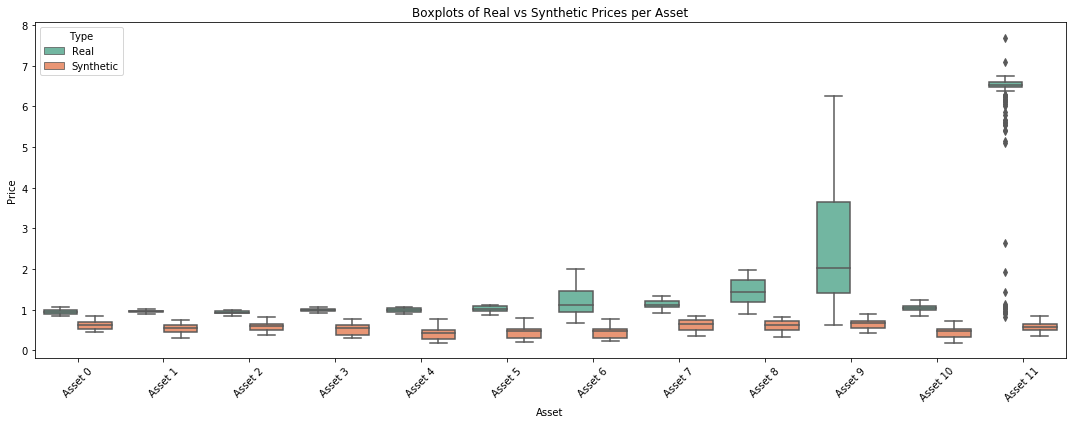

In [60]:
# -- COLLECT FINAL PRICE TRAJECTORIES FOR COMPARISON --
real_all, synthetic_all = [], []
for asset_index in range(NUM_ASSETS):
    prices_real = np.cumprod(1 + raw_returns_all_assets[-300:, asset_index])
    G.eval()
    with torch.no_grad():
        z = torch.randn(1, config.z_size).to(device)
        synthetic = G(z).cpu().numpy().flatten()
        returns_unscaled = scaler.inverse_transform(synthetic.reshape(-1, 1)).flatten()
        prices_synth = [prices_real[0]]
        for r in returns_unscaled:
            prices_synth.append(prices_synth[-1] * (1 + r))
        prices_synth = prices_synth[1:]

    real_all.append(prices_real)
    synthetic_all.append(prices_synth)

plot_boxplots(real_all, synthetic_all)

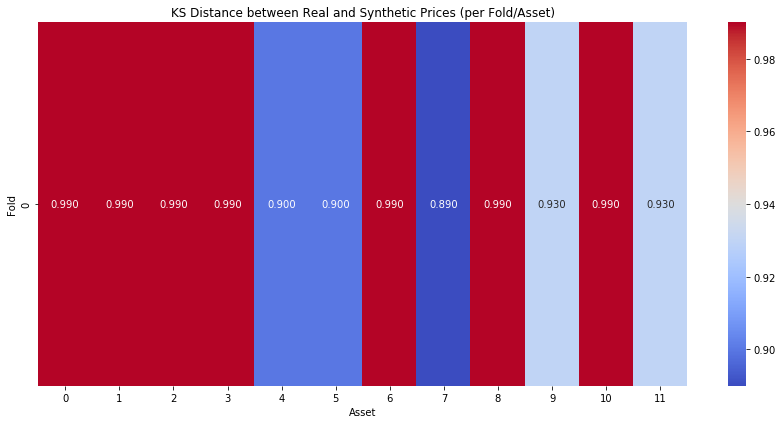

In [61]:
# -- KS DISTANCE HEATMAP --
ks_matrix = results_df.pivot(index="Fold", columns="Asset", values="KS_Distance")
plt.figure(figsize=(12, 6))
sns.heatmap(ks_matrix, annot=True, fmt=".3f", cmap="coolwarm")
plt.title("KS Distance between Real and Synthetic Prices (per Fold/Asset)")
plt.ylabel("Fold"); plt.xlabel("Asset")
plt.tight_layout(); plt.savefig("ks_distance_heatmap.png"); plt.show()

In [66]:
# -- 🔮 Synthetic Forecast Generation from Final Model --

# Final known real prices used to bootstrap synthetic price paths
LAST_KNOWN_PRICES = np.array([
    15.136, 20.3352, 17.563, 8.6973, 1.1579, 1.3435,
    20.716, 141.5, 164.252, 9.95, 30.14, 2004.0
])

# Put generator in evaluation mode and generate a synthetic forecast
G.eval()
synthetic_df = generate_synthetic_forecast(G)
display(synthetic_df.head())


ValueError: Shape of passed values is (300, 1), indices imply (300, 12)

In [67]:
# -- 📊 Compare Real vs Synthetic Return Distributions --

# These variables must be defined in your CV loop:
# - `val_seq`: validation returns from the most recent TSCV fold
# - `returns`: synthetic returns from the generator
real_returns_flat = val_seq.flatten()
synthetic_returns_flat = returns.flatten()

# Evaluate and display stylized statistical metrics
metrics_df = evaluate_synthetic_vs_real(real_returns_flat, synthetic_returns_flat)
print(metrics_df.to_string(index=False))

 Mean_Real  Mean_Synthetic  Std_Real  Std_Synthetic  Skew_Real  Skew_Synthetic  Kurt_Real  Kurt_Synthetic  KS_Distance  Jarque_Bera_Real  Jarque_Bera_Synthetic
  0.028898        0.020622  0.933006       0.193035   6.133508       10.928279  49.433831      195.867231     0.538306      10809.097061           1.098896e+06


In [68]:

# -- 📉 Dimensionality Reduction Visualization --


def plot_dimensionality_reduction(real_all, synthetic_all, method="PCA"):
    """
    Visualize differences between real and synthetic price trajectories
    using PCA or t-SNE for dimensionality reduction.

    Parameters:
        real_all, synthetic_all: list of 1D price arrays per asset
        method (str): "PCA" or "tSNE"
    """
    all_series = []
    labels = []

    # Flatten and label all real and synthetic price series
    for i, series in enumerate(real_all):
        all_series.append(series)
        labels.append(f"Real_{i}")
    for i, series in enumerate(synthetic_all):
        all_series.append(series)
        labels.append(f"Synth_{i}")

    X = np.array(all_series)

    # Choose dimensionality reduction method
    if method == "PCA":
        reducer = PCA(n_components=2)
    elif method == "tSNE":
        reducer = TSNE(n_components=2, perplexity=5, learning_rate='auto', init='random', random_state=42)
    else:
        raise ValueError("Method must be 'PCA' or 'tSNE'.")

    # Reduce dimensionality
    X_reduced = reducer.fit_transform(X)

    # Format results for plotting
    df_plot = pd.DataFrame({
        "x": X_reduced[:, 0],
        "y": X_reduced[:, 1],
        "Type": ["Real"] * len(real_all) + ["Synthetic"] * len(synthetic_all),
        "Asset": [f"A{i}" for i in range(len(real_all))] * 2
    })

    # Create scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_plot, x="x", y="y", hue="Type", style="Asset", s=100)
    plt.title(f"{method} Projection of Real vs Synthetic Prices")
    plt.tight_layout()
    plt.savefig(f"{method.lower()}_price_trajectories.png")
    plt.show()

# -- 📈 Run Dimensionality Reduction Plots --
plot_dimensionality_reduction(real_all, synthetic_all, method="PCA")
plot_dimensionality_reduction(real_all, synthetic_all, method="tSNE")


# -- 🖼️ Plot Final Generator Output Sample --
fixed_noise = torch.randn(1, 100).to(device)
plot_result(G, fixed_noise, image_size=1, num_epoch="final", save_dir=".", n_series=12)


ValueError: setting an array element with a sequence.